In [1]:
import matplotlib.pyplot as plt
import numpy as nm
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import math
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb

In [2]:
folder = 'C:\\Users\\vswen\\Documents\\1. Biomedische Technologie\\BMT JAAR 5\\Kwart 4\\4. Data\\CTRPv2.0_2015_ctd2_ExpandedDataset\\'

# Import data
complete_df = pd.read_csv(f"{folder}scaffold_split.txt", sep="\t")
# complete_df.fillna(complete_df.mean(), inplace=True)

In [3]:
# Fingerprint aanmaken
molecules = [Chem.MolFromSmiles(smile) for smile in complete_df['cpd_smiles'].tolist()]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=1024) for molecule in molecules]
complete_df['ecfp_bit_vectors'] = [[int(bit) for bit in keys.ToBitString()] for keys in ecfp]
complete_df['ECFP'] = [''.join(str(value) for value in row) for row in complete_df['ecfp_bit_vectors']]


In [4]:
# Doelvariabele transformeren & limieten stellen dataframe
complete_df['ec50_mol'] = complete_df['apparent_ec50_umol'] / 1000000
complete_df['ec50_mol']=complete_df['ec50_mol'].replace(0, 1e-10)
complete_df['ec50_molair'] = complete_df['ec50_mol']/ complete_df['MolWt']
complete_df['ec50_molair_transformed'] = -nm.log10(complete_df['ec50_molair'])
condition = (complete_df['ec50_molair_transformed'] < 2) | (complete_df['ec50_molair_transformed'] > 10)
complete_df=complete_df[~condition]

In [5]:
total_length_compounds = len(complete_df)
size_train_set = total_length_compounds * 0.8 # Uitgaande van idealiter een 0.8:0.2 verhouding tussen train en test

In [6]:
# Creeer een DF voor alle scaffolds die uniek zijn
df_unique_scaffolds = complete_df[complete_df['recurring_scaffold'] == 0]
df_unique_scaffolds = df_unique_scaffolds[['recurring_scaffold', 'ecfp_bit_vectors', 'ec50_molair_transformed']]

# Extraheer de X en Y value van de nieuwe DF 
## X is de te gebruike compound waarde  | Fingerprint ECFP
## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
x_unique = nm.array(df_unique_scaffolds['ecfp_bit_vectors'].tolist())
y_unique = df_unique_scaffolds['ec50_molair_transformed'].values

In [7]:
# Creeer een DF voor alle scaffolds die meermaals voorkomen
df_grouped_scaffolds = complete_df[complete_df['recurring_scaffold'] > 0]
df_grouped_scaffolds = df_grouped_scaffolds[['ecfp_bit_vectors', 'ec50_molair_transformed', 'recurring_scaffold']]

# Extraheer de X, Y en Z value van de nieuwe DF
## X is de te gebruike compound waarde  | Fingerprint ECFP
## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
## Z is de indicator voor overeenkomstige scaffold groepen | Elke scaffoldgroup een eigen numerieke waarde
x_grouped = nm.array(df_grouped_scaffolds['ecfp_bit_vectors'].tolist())
y_grouped = df_grouped_scaffolds['ec50_molair_transformed'].values
z_grouped = df_grouped_scaffolds['recurring_scaffold'].values.tolist()
print(z_grouped)

#df_grouped_scaffolds_indexes = df_grouped_scaffolds.groupby('recurring_scaffold')

[23, 22, 22, 21, 21, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 12, 12, 11, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 5, 5, 4, 4, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1]


In [8]:
size_train_set_grouped_scaffolds = len(z_grouped) * 0.8
size_train_set_grouped_scaffolds = int(size_train_set_grouped_scaffolds)
print(size_train_set_grouped_scaffolds)

39


In [9]:
# Creeeren van lege lijsten voor de Grouped Scaffolds
x_train_grouped = []
y_train_grouped = []
x_test_grouped = []
y_test_grouped = []

In [10]:
for x in range(len(z_grouped)):
    if x < size_train_set_grouped_scaffolds:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    elif z_grouped[x] == z_grouped[x-1]:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    else: 
        remaining = len(z_grouped)-x
        break
        
for x in range(remaining):
    x_test_grouped.append(x_grouped[x+remaining])
    y_test_grouped.append(y_grouped[x+remaining])

In [11]:
print(len(x_train_grouped))
print(len(x_test_grouped))
print(y_train_grouped[0:5])
print(y_test_grouped[0:5])

39
10
[6.177467919143146, 5.177786810229625, 3.06292216546177, 4.149560588087753, 5.585250661642195]
[3.5424595779947636, 3.8039684526979833, 7.002867750366318, 7.140120040530652, 4.799117455495654]


In [12]:
x_train_grouped = [list(arr) for arr in x_train_grouped]
x_test_grouped = [list(arr) for arr in x_test_grouped]

In [13]:
from sklearn.model_selection import train_test_split
x_train_unique,x_test_unique,y_train_unique,y_test_unique=train_test_split(x_unique,y_unique,test_size=0.2, random_state=42)

In [14]:
y_train_grouped[0]
y_train_unique[0]

4.414802598112664

In [15]:
x_train = nm.concatenate((x_train_grouped, x_train_unique))
x_test = nm.concatenate((x_test_grouped, x_test_unique))

y_train = nm.concatenate((y_train_grouped, y_train_unique))
y_test = nm.concatenate((y_test_grouped, y_test_unique))

In [16]:
print('TRAIN DATA')
print('y_train', len(y_train), y_train)
print('x_train', len(x_train), x_train)

print('TEST DATA')
print('x_test', len(x_test), x_test)
print('y_test', len(y_test), y_test)

TRAIN DATA
y_train 320 [6.17746792 5.17778681 3.06292217 4.14956059 5.58525066 2.50198468
 3.91956742 3.34657922 5.11197086 5.54643757 3.54245958 3.80396845
 7.00286775 7.14012004 4.79911746 7.97837982 5.92818719 8.99517549
 4.88020939 7.8379193  9.17434816 3.66170099 3.5604241  4.32983641
 9.23652481 4.92716807 3.85277385 5.85993903 4.47004173 3.26310969
 4.48432501 4.05652758 4.75146563 2.7613362  3.31549143 5.15262715
 3.24403851 3.89107571 3.57066811 4.4148026  5.28067871 4.45362039
 6.35001835 4.15936162 7.23431301 4.31004416 3.84217479 4.37302502
 5.33616141 6.41357527 3.64261256 7.55637684 5.40446363 3.28515583
 5.02197313 3.90738631 5.80930103 3.38998186 4.55845424 3.39353677
 4.25197765 4.25410048 2.30035178 3.06292054 4.5964414  6.80647327
 4.75016375 4.26947641 6.30261421 7.90763278 3.02389717 4.60472351
 3.45807149 4.00074561 3.7719123  4.2971958  8.22021806 5.51279443
 8.99634707 4.65229718 3.2906463  6.49235756 4.7613378  5.43086399
 3.08972882 3.13343813 3.91586322 6.411

In [18]:
# Fit XGBoost-regressiemodel
model = xgb.XGBRegressor()
grid = xgb.XGBRegressor(colsample_bytree= 0.8, learning_rate= 0.01, max_depth= 3, n_estimators= 500, subsample= 0.8)
grid.fit(x_train,y_train)

# Predict Test result
y_pred=grid.predict(x_test)

In [19]:
# Errors berekenen
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error
mae=mean_absolute_error(y_test, y_pred)
print('mean absolute error is ', mae)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print('mean squared error is ', mse)

# Root Mean Squared Error
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_test,y_pred,1)
line = slope * nm.array(y_test)+ intercept
r2 = r2_score(y_test, y_pred)
print('r2 is', r2)

residuen_scaffold = y_test-y_pred

mean absolute error is  1.1094253893589818
mean squared error is  2.3398033990489355
root mean squared error is  1.5296415916968704
r2 is 0.08975775584489987


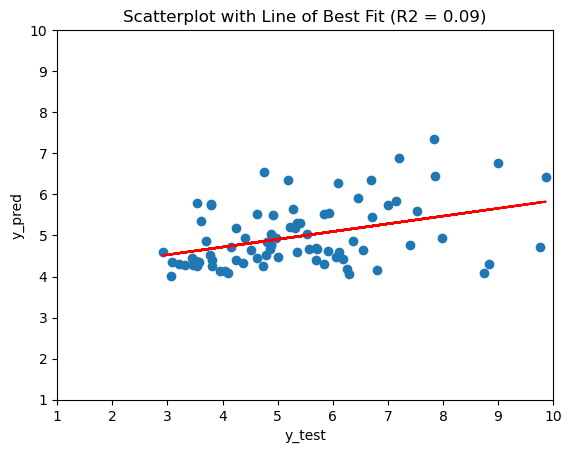

In [20]:
# R2 Visualisatie scatterplot
slope, intercept = nm.polyfit(y_test,y_pred,1)
line = slope * nm.array(y_test)+ intercept
plt.scatter(y_test,y_pred)
plt.plot(y_test, line, color='red', label='line of current best fit')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.xlim(1,10)
plt.ylim(1,10)
plt.title('Scatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()

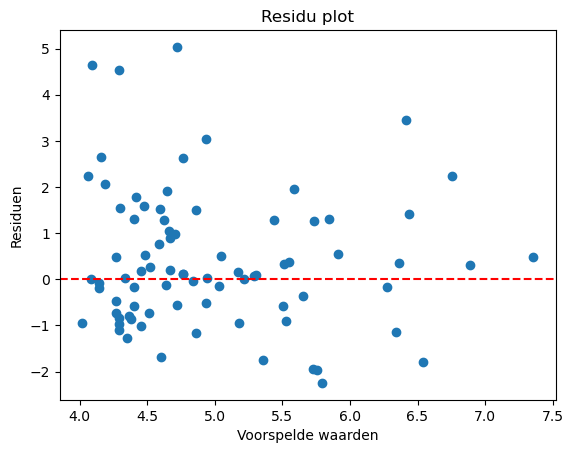

In [21]:
# Visualisatie residu plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Voorspelde waarden')
plt.ylabel('Residuen')
plt.title('Residu plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


r2 is -0.06375586240817666


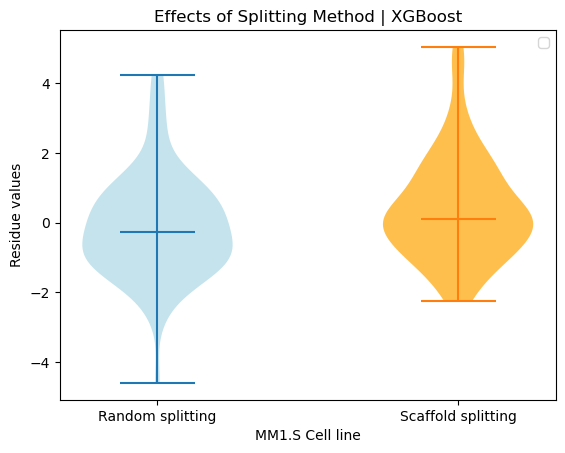

In [23]:
            import numpy as np
          # Dependent & Independent variable
x = nm.array(complete_df['ecfp_bit_vectors'].tolist())
y = complete_df['ec50_molair_transformed'].values

# Split Test & Train
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200, min_samples_split=5,min_samples_leaf=4,max_depth=10,bootstrap=True)
regressor.fit(x_train,y_train)

# Predict Test result
y_pred = regressor.predict(x_test)

# Errors berekenen
from sklearn.metrics import r2_score

# R2 berekenen
slope, intercept = nm.polyfit(y_test,y_pred,1)
line = slope * nm.array(y_test)+ intercept
r2 = r2_score(y_test, y_pred)
print('r2 is', r2)

residuen_random  = y_test - y_pred

fig, ax = plt.subplots()

# Plot de violinplots voor beide modellen
parts_random = ax.violinplot(residuen_random, showmeans=False, showmedians=True, showextrema=True, positions=[0])
parts_scaffold = ax.violinplot(residuen_scaffold, showmeans=False, showmedians=True, showextrema=True, positions=[1])

# Aanpassen van de kleuren van de indicatoren
for pc in parts_random['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)

for pc in parts_scaffold['bodies']:
    pc.set_facecolor('orange')
    pc.set_alpha(0.7)

# Opmaak van de plot
ax.set_xlabel('MM1.S Cell line')
ax.set_ylabel('Residue values')
ax.set_title('Effects of Splitting Method | XGBoost')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Random splitting', 'Scaffold splitting'])


# Legenda tonen
ax.legend()

# Toon de plot
plt.show()